<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

---

A common application for AR, ARMA, and ARIMA models is inventory planning. Planning inventory for a small shop can be difficult enough, but you've just been hired to plan inventory for a _big_ store - Walmart.

In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012. The data is separated by store and by department, but you should focus on analyzing one store for simplicity. 

Try your best to tune your model. It can be difficult, but don't worry - timeseries analysis is just a difficult and specialized topic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm

sns.set(font_scale=1.5)
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# get the dataset
data = pd.read_csv('../../../../resource-datasets/walmart_stores/train.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True, drop=True)
data.index.name = None
data.head()

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


## Look back at the lesson notes for information about these models and acf/pacf plots

- [1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.](#filter)
- [2. Plot the rolling_mean for `Weekly_Sales`. What general trends do you observe?](#rolling)
- [3. Compute the 1, 2, 52 autocorrelations for `Weekly_Sales` and create an autocorrelation and partial autocorrelation plot.](#acf)
- [4. *BONUS:* What do the acf() and pacf() plots say about the type of model you want to build?](#interpretation)
- [5. Split the weekly sales data in a training and test set - using 75% of the data for training.](#train-test)
- [6. "Difference" the data by converting the sales into change in sales (diff function is convenient for doing this.)](#diff)
- [7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. How effective is this model?](#AR1)
- [8. Plot the residuals - where are their significant errors?](#residuals)
- [9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?](#AR2)
- [10. Assemble your findings including any useful graphs.](#summary)

<a id='filter'></a>
### 1. Filter the dataframe to Store 1 sales and aggregate over departments to compute the total sales per store.

In [3]:
# there are about 36 different stores in this dataset.

In [4]:
data.head(2)

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True


In [5]:
data.Store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [6]:
data[(data["Store"]==1) & (data["Dept"]==1)].head()

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-05,1,1,24924.50,False
2010-02-12,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-03-05,1,1,21827.90,False


In [7]:
store1 = data[(data["Store"]==1)].resample("w").sum()

In [8]:
store1.head(2)

,Store,Dept,Weekly_Sales,IsHoliday
2010-02-07,73,3184,1643690.90,0.0
2010-02-14,72,3137,1641957.44,72.0


In [9]:
store1=store1.drop(["Store","Dept","IsHoliday"],axis=1)

In [10]:
store1.head(2)

,Weekly_Sales
2010-02-07,1643690.90
2010-02-14,1641957.44


<a id='rolling'></a>
### 2. Plot the rolling_mean for Weekly_Sales. What general trends do you observe?

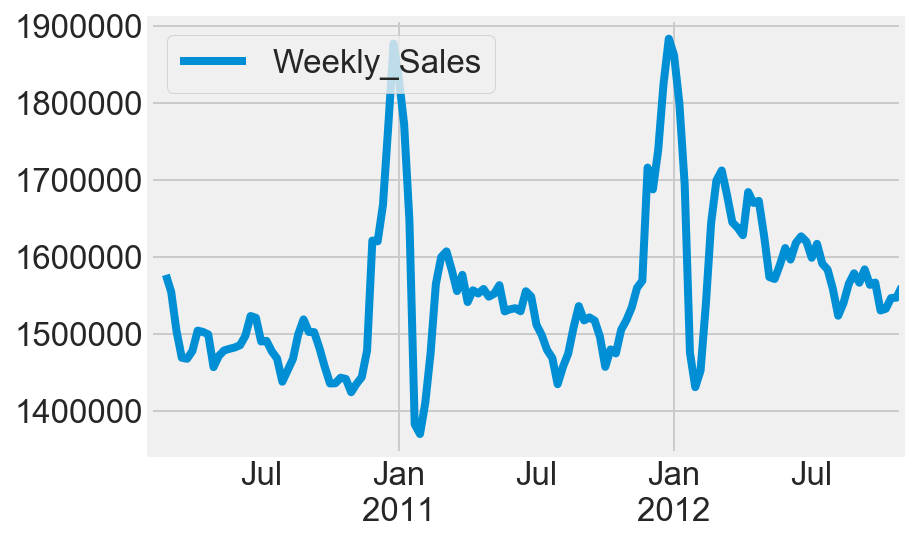

In [11]:
store1.rolling(4).mean().plot()

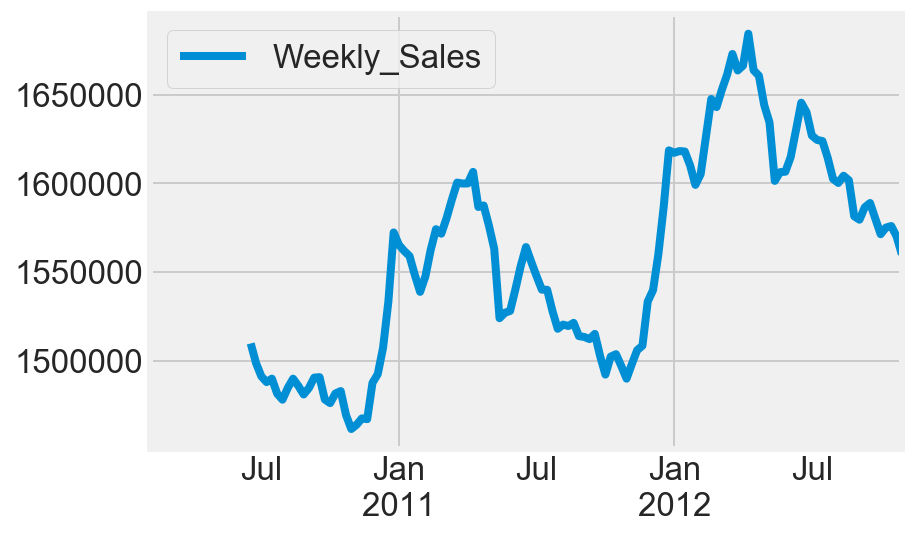

In [12]:
store1.rolling(20).mean().plot()

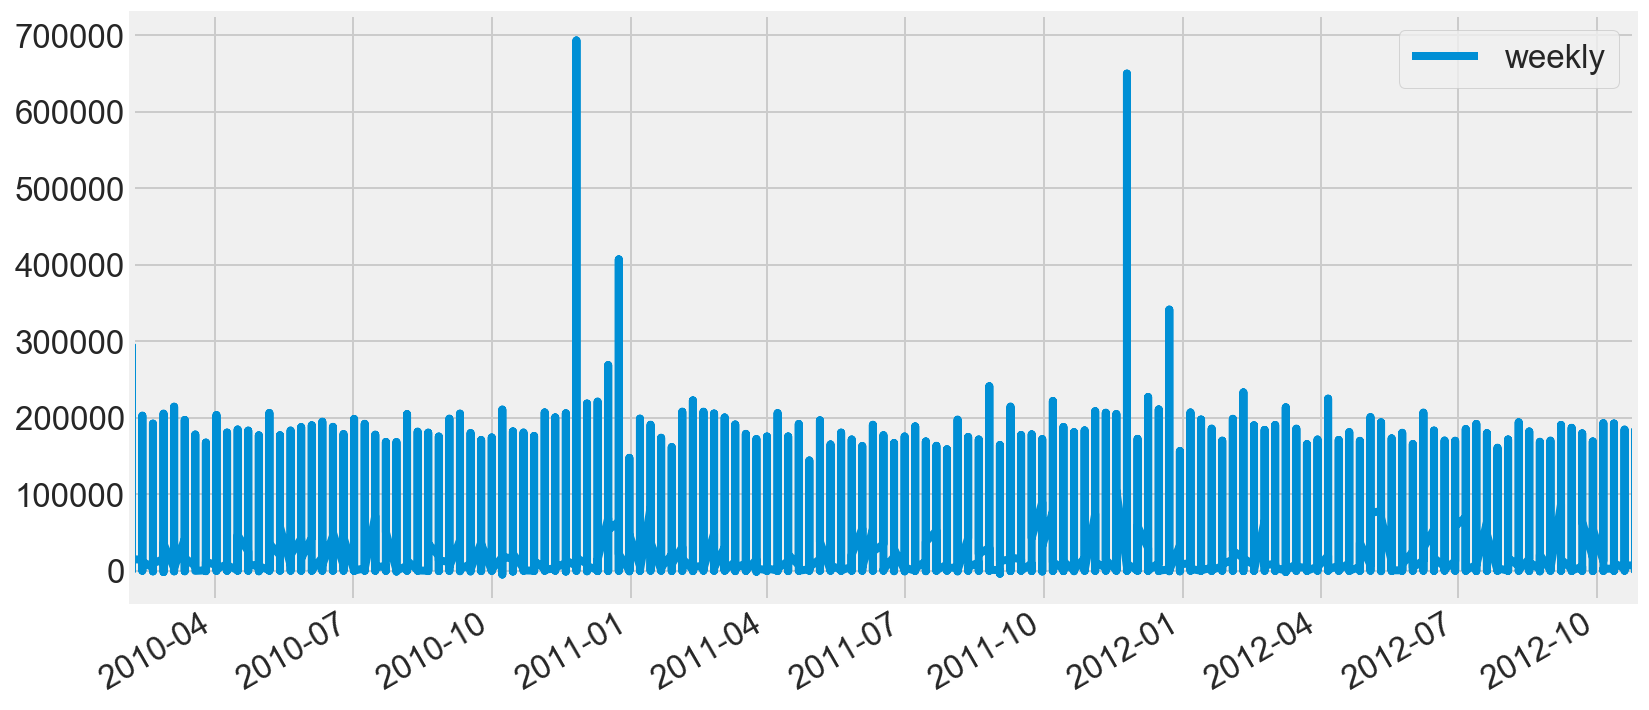

In [13]:
plt.figure(figsize=(12, 6))
data.Weekly_Sales.plot(label='weekly', legend=True)
plt.show()

<a id='acf'></a>
### 3. Compute the 1, 2, 52 autocorrelations for Weekly_Sales and create an autocorrelation and partial autocorrelation plot.

In [14]:
def autocorr_plots(y, lags=20, alpha=0.05):
    """
    Plot autocorrelations and partial autocorrelations
    Arguments:
    y: Time series
    lags: Number of lags to plot
    alpha: Confidence level for random noise
    """

    se = stats.norm().ppf(1-alpha/2)/np.sqrt(len(y))

    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

    plot_acf(y, lags=lags, alpha=alpha, ax=ax[0])
    ax[0].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    plot_pacf(y, lags=lags, alpha=alpha, ax=ax[1], method='ywmle')
    ax[1].hlines(np.array([-1, 1])*se, 1, lags, linestyles='--', lw=1)

    return fig, ax

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [16]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

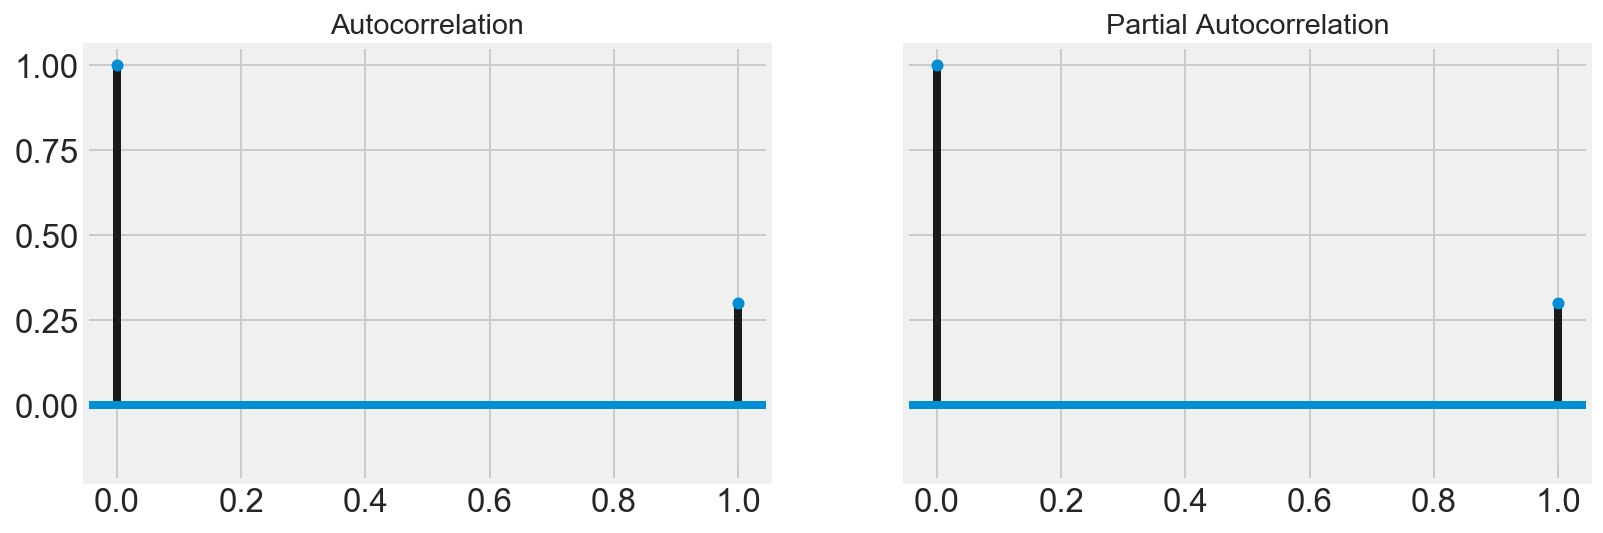

In [17]:
fig, ax = autocorr_plots(store1.Weekly_Sales, lags=1)

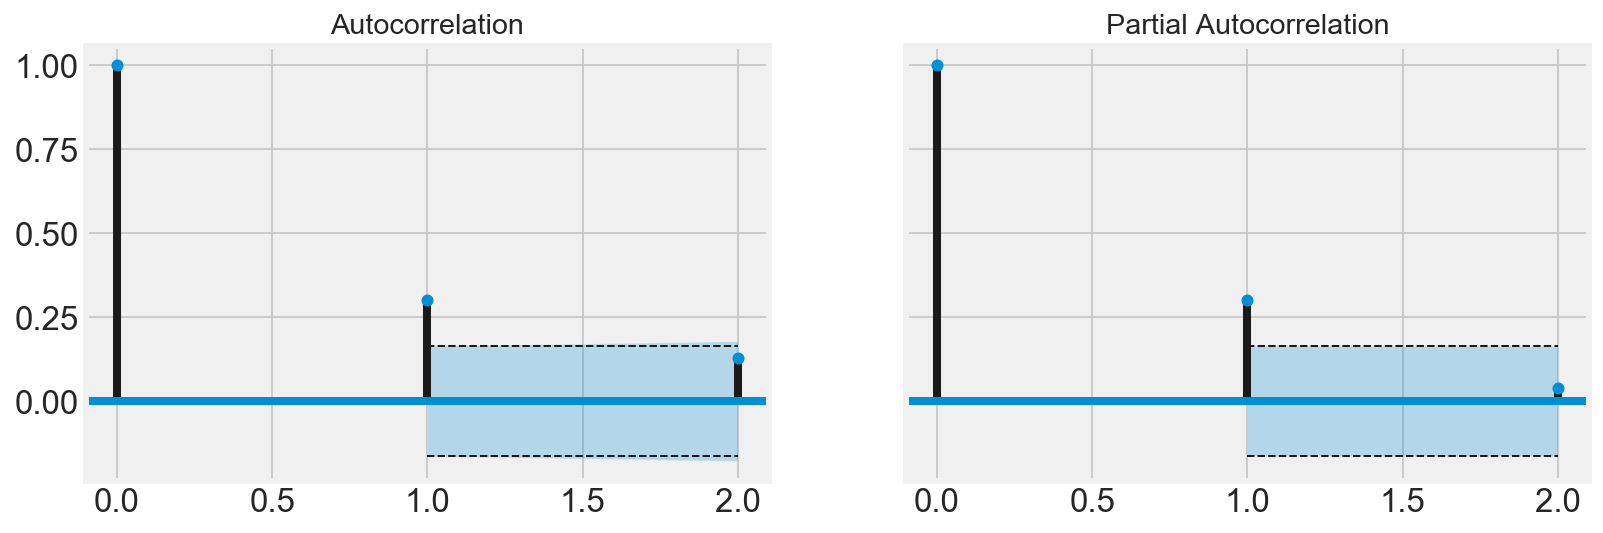

In [18]:
fig, ax = autocorr_plots(store1.Weekly_Sales, lags=2)

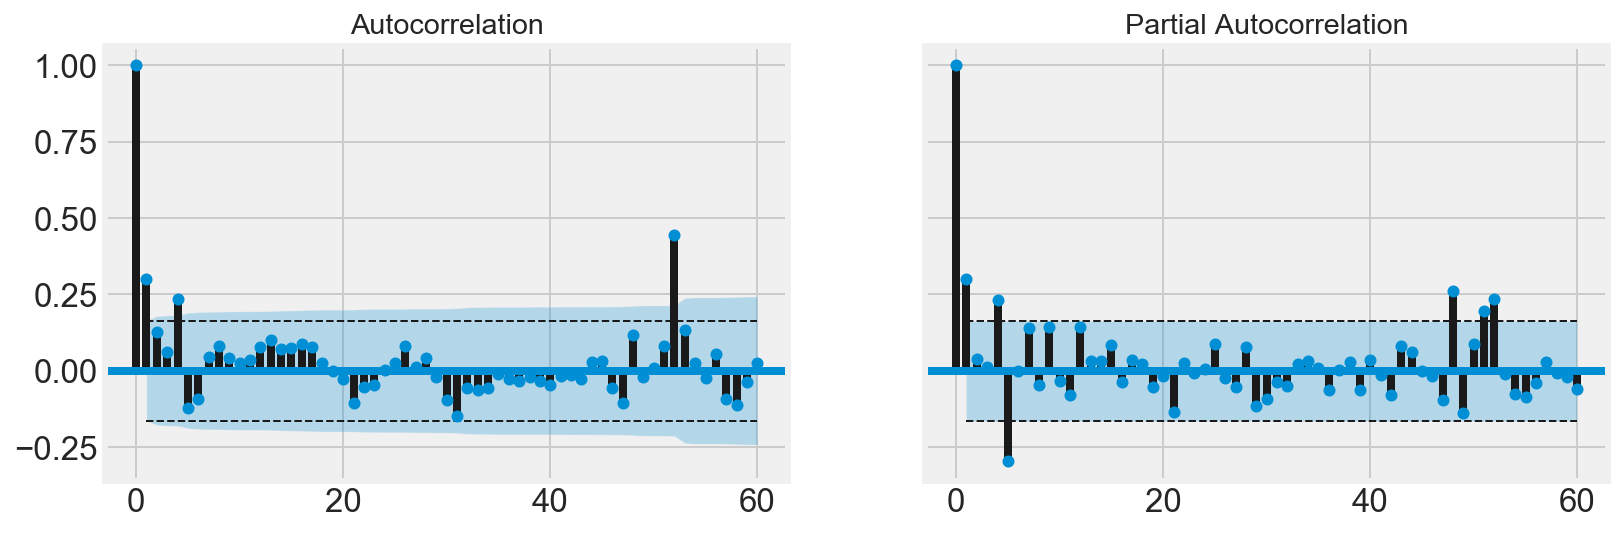

In [26]:
fig, ax = autocorr_plots(store1.Weekly_Sales, lags=60)

<a id='interpretation'></a>
### 4. BONUS: What do the acf and pacf plots say about the type of model you want to build?


<a id='train-test'></a>
### 5. Split the weekly sales data in a training and test set - using 75% of the data for training.

In [20]:
train_num=round(store1.shape[0]*0.75)
test_num=round(store1.shape[0]*0.25)
train_num

107

In [21]:
store1_train=store1[:train_num]

In [22]:
store1_test = store1[train_num:]

<a id='diff'></a>
### 6. "Difference" the data by converting the sales into change in sales 

In [23]:
store1_train_diff=store1_train.diff().dropna()

In [24]:
store1_test_diff=store1_test.diff().dropna()

<a id='AR1'></a>
### 7. Fit an AR(1) model on the training data and compute the mean squared error of the predictions. 
####    How effective is this model?

In [25]:
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import mean_squared_error

<a id='residuals'></a>
### 8. Plot the residuals - where are their significant errors?

<a id='AR2'></a>
### 9. Fit an AR(2) model and an ARMA(2, 2) model - does this improve your mean squared error on the held out set?

<a id='summary'></a>
### 10. Assemble your findings including any useful graphs.